In [70]:
from datetime import datetime

import torch
import numpy as np


import util, tr_util
from Dimploma import old_gcn
from my_gcn import GCN
from Dimploma.EnvironmentTree import EnvMinimalTreeTwoStep
from Dimploma.ppo_parallel_custom import Agent, test_random
from Dimploma.utils.graph_provider import GraphProvider

In [3]:
%load_ext autoreload
%autoreload 2

device:  cpu
Loading graph


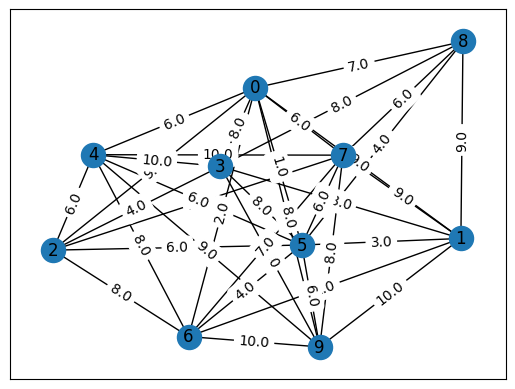

Name: n10_e36_norm
tensor([[0, 0, 0, 2, 0, 0, 9, 5, 5, 2, 6, 1, 3, 2, 1, 5, 9, 7, 5, 6, 9, 0, 8, 6,
         4, 5, 5, 0, 3, 5, 8, 8, 2, 1, 7, 0],
        [2, 9, 8, 6, 5, 1, 7, 4, 3, 7, 0, 3, 9, 5, 9, 8, 4, 6, 7, 1, 6, 7, 7, 4,
         2, 6, 9, 3, 4, 1, 1, 3, 3, 7, 4, 4]]) tensor([[ 0.9000,  0.0000,  9.0000],
        [ 0.8000,  0.0000,  8.0000],
        [ 0.7000,  0.0000,  7.0000],
        [ 0.8000,  0.0000,  8.0000],
        [ 0.1000,  0.0000,  1.0000],
        [ 0.9000,  0.0000,  9.0000],
        [ 0.8000,  0.0000,  8.0000],
        [ 0.6000,  0.0000,  6.0000],
        [ 0.8000,  0.0000,  8.0000],
        [ 0.2000,  0.0000,  2.0000],
        [ 0.2000,  0.0000,  2.0000],
        [ 0.8000,  0.0000,  8.0000],
        [ 0.8000,  0.0000,  8.0000],
        [ 0.6000,  0.0000,  6.0000],
        [ 1.0000,  0.0000, 10.0000],
        [ 0.4000,  0.0000,  4.0000],
        [ 0.9000,  0.0000,  9.0000],
        [ 0.7000,  0.0000,  7.0000],
        [ 0.6000,  0.0000,  6.0000],
        [ 0.1000,  0.00

In [71]:
node_amount = 10
edge_amount = int(45*0.8)
iteration_amount = 1500
epoch_amount = 10
batch_size = 64
node_features = 2  # (index, {0,1} selected or not)
steps_amount = int((node_amount - 1)*2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)

cat_in_net = True
conv_layers = 3
conv_p_layers = 1
linear_layers = 2


gamma=0.99
epsilon=0.1
coef_value=0.5
coef_entropy=0.001
gae_lambda=0.95
lr=0.00025


fixed_graph = True
# load_graph = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/graph.pt'
load_graph = 'graphs/graph1_norm.pt'
# load_graph = ''
# load_from = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/models/iter_499_last.pt'
# load_from = 'results/min_tree_ppo/node/250103_18#n10_e45_not_fixed/models/iter_999_last.pt'
load_from = ''
graph = None

if load_graph != '':
    print('Loading graph')
    graph = torch.load(load_graph)
    util.show_data(graph)
elif fixed_graph:
    print('Fixing graph')
    graph = util.generate_random_graph_add_method(node_amount, edge_amount, device=device)
    util.show_data(graph)

graph_provider = GraphProvider(fixed_graph=graph, device=device, nodes=node_amount, edges=edge_amount)


name = f'n{node_amount}_e{edge_amount}_norm'

training_desc = f'''
loading the graph from the lrInc train to test if it was luck
trying out training with:
fixed graph
{conv_layers}-{conv_p_layers}GAT layers
{'with' if cat_in_net else 'without'} catenation between layers
{iteration_amount} iterations

Parameters:
Gamma: {gamma}
Epsilon: {epsilon}
Coef_value: {coef_value}
Coef_Entropy: {coef_entropy}
Gae_lambda: {gae_lambda}
Learning rate: {lr}
'''

path = 'results/min_tree_ppo/node/'
last_path = f'models/iter_{iteration_amount - 1}_last.pt'
print("Name:", name)
if fixed_graph:
    print(graph.edge_index, graph.edge_attr, graph.x)

In [72]:
last_name = "fuckup"

In [73]:
start_date = datetime.now()

try:
    # noinspection PyUnresolvedReferences
    if last_name == name:
        raise Exception("You should change the name :D")
except NameError:
    raise Exception("You should init last name :D")

if training_desc == '':
    raise Exception("You should write a nice description :D")

last_name = name

net = GCN(node_amount, node_features, cat_in_net, conv_layers, conv_p_layers, linear_layers)

print(f'Agent {name}')

agent = Agent(model=net, gamma=gamma, epsilon=epsilon, coef_value=coef_value, coef_entropy=coef_entropy, gae_lambda=gae_lambda, lr=lr, device=device, path=path, name=name, override=True, early_stop=True)
# agent = Agent(model=net, device=device, path=path, name=name, override=True)

if load_from != '':
    agent.load_model(load_from)

agent.training_description(training_desc)
training_desc = ''
# agent.train([device, None, node_amount, edge_amount], EnvMinimalTreeTwoStep, node_amount, count_of_processes=1, count_of_envs=1, batch_size=32, count_of_iterations=iteration_amount)
agent.train([graph_provider], EnvMinimalTreeTwoStep, node_amount, count_of_iterations=iteration_amount, count_of_epochs=epoch_amount, batch_size=batch_size, count_of_steps=steps_amount)


end_date = datetime.now()
torch.save(graph, agent.path + '/graph.pt')
s = (end_date - start_date).seconds
hours, remainder = divmod(s, 3600)
minutes, seconds = divmod(remainder, 60)
#-1.42077
print(f'Time training {int(hours):02}:{int(minutes):02}:{int(seconds):02}')

Agent n10_e36_norm
Training is starting
Iteration 0 starting
Iteration 0	episode 32	avg score 0.01660	best score 0.40625	best avg score 0.01660
Writing to early val: 0.0166015625
Iteration 1 starting
Iteration 1	episode 64	avg score -0.01270	best score 0.40625	best avg score 0.01660
Iteration 2 starting
Iteration 2	episode 96	avg score 0.02865	best score 0.40625	best avg score 0.02865
Iteration 3 starting
Iteration 3	episode 128	avg score 0.01406	best score 0.53125	best avg score 0.02865
Iteration 4 starting
Iteration 4	episode 160	avg score 0.03406	best score 0.53125	best avg score 0.03406
Iteration 5 starting
Iteration 5	episode 192	avg score 0.03188	best score 0.53125	best avg score 0.03406
Iteration 6 starting
Iteration 6	episode 224	avg score 0.04375	best score 0.53125	best avg score 0.04375
Iteration 7 starting
Iteration 7	episode 256	avg score 0.03969	best score 0.53125	best avg score 0.04375
Iteration 8 starting
Iteration 8	episode 288	avg score 0.06375	best score 0.53125	best 

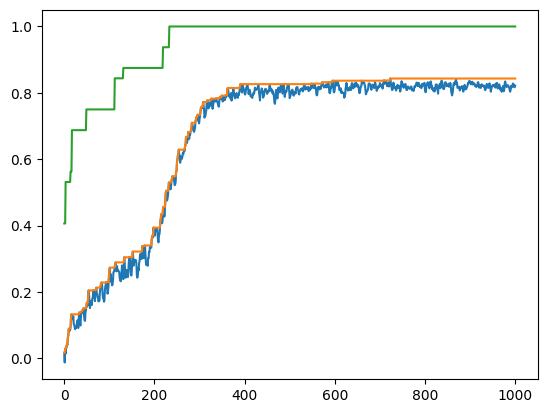

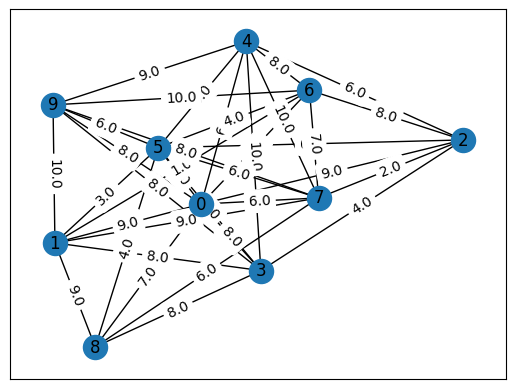

Loading model from results/min_tree_ppo/node/250207_15#n10_e36_norm//models/iter_1499_last.pt


In [74]:
loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing(agent.path, iteration_amount, graph_provider, GCN(node_amount, node_features, cat_in_net, conv_layers, conv_p_layers, linear_layers), device)

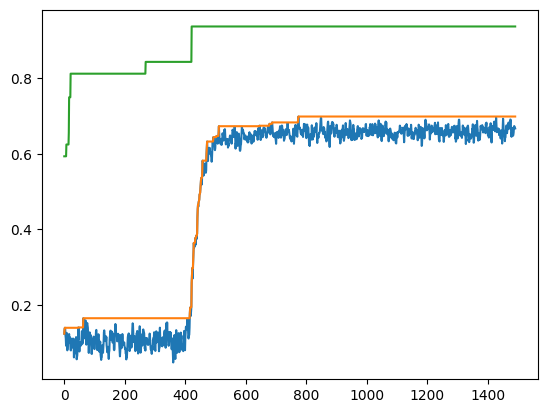

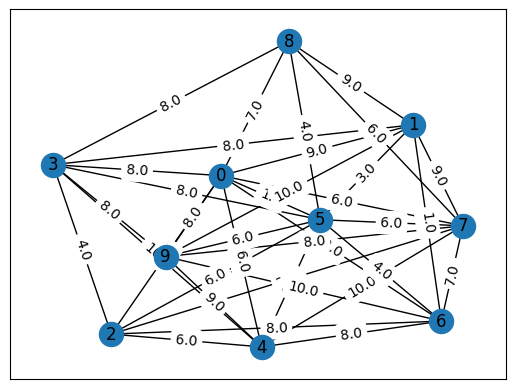

Loading model from results/min_tree_ppo/node/250204_20#n10_e36_eps03/models/iter_1499_last.pt


In [21]:
# loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing('results/min_tree_ppo/node/250204_20#n10_e36_eps03', 1500, graph_provider, old_gcn.GCN31(node_amount, node_features), device)

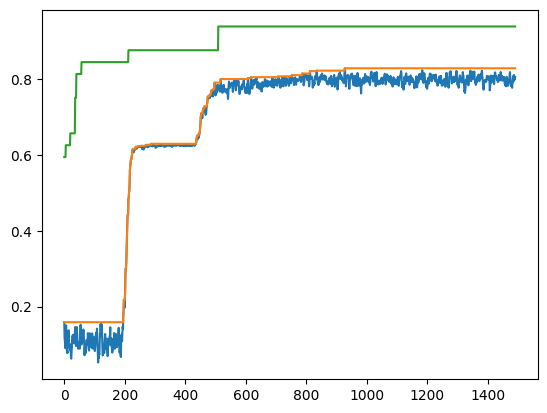

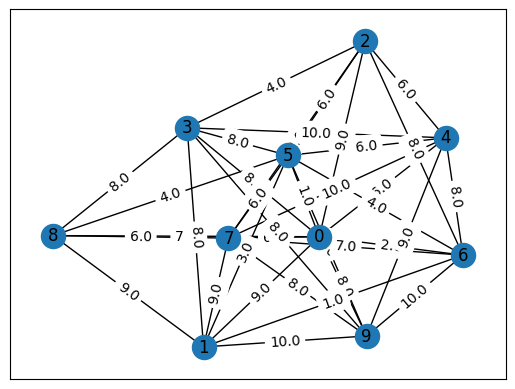

Loading model from results/min_tree_ppo/node/250205_13#n10_e36_eps02/models/iter_1499_last.pt


In [24]:
# loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing('results/min_tree_ppo/node/250205_13#n10_e36_eps02', 1500, graph_provider, old_gcn.GCN31(node_amount, node_features), device)

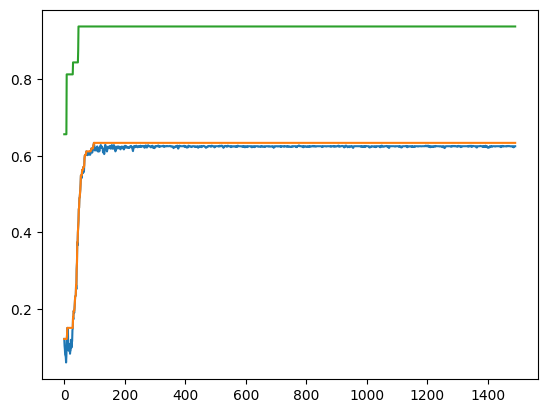

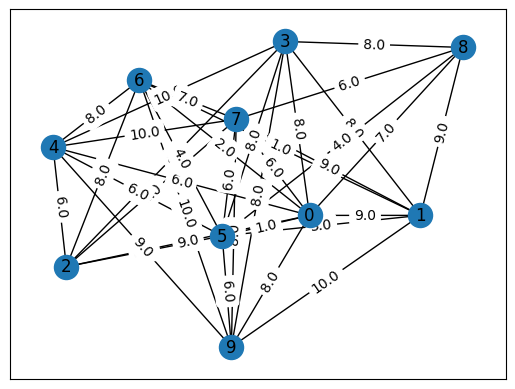

Loading model from results/min_tree_ppo/node/250205_16#n10_e36_gat2-1_at2/models/iter_1499_last.pt


In [25]:
# loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing('results/min_tree_ppo/node/250205_16#n10_e36_gat2-1_at2', 1500, graph_provider, old_gcn.GCN21(node_amount, node_features), device)

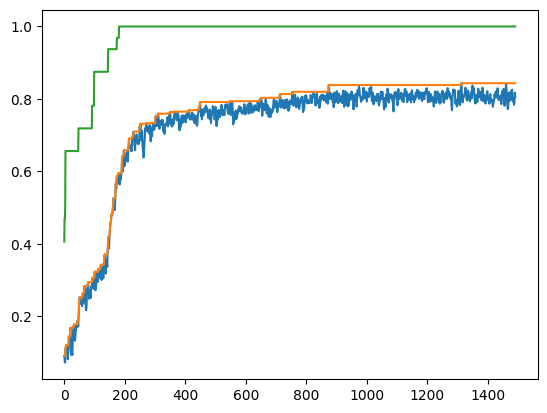

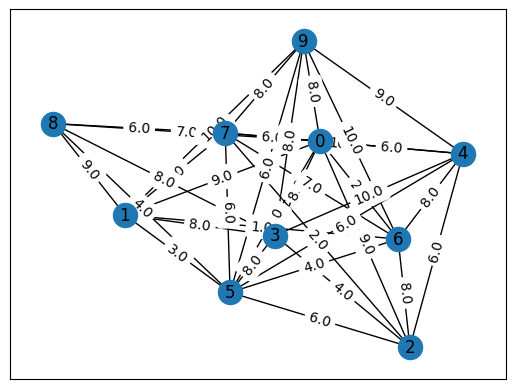

Loading model from results/min_tree_ppo/node/250205_19#n10_e36_gat3-2_at2/models/iter_1499_last.pt


In [55]:
# loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing('results/min_tree_ppo/node/250205_19#n10_e36_gat3-2_at2', 1500, graph_provider, old_gcn.GCN32(node_amount, node_features), device)

In [75]:
# Testing
test_amount = 100
objs_test = np.zeros(test_amount, dtype=np.float32)
rews_test = np.zeros(test_amount, dtype=np.float32)
actions_test = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

objs_test_r = np.zeros(test_amount, dtype=np.float32)
rews_test_r = np.zeros(test_amount, dtype=np.float32)
actions_test_r = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

for i in range(test_amount):
    obj, sel, rew, acts = agent_test.test(test_env)
    objs_test[i] = obj
    rews_test[i] = rew[-1]
    actions_test[i, :len(acts)] = acts
    
    obj_r, sel_r, rew_r, acts_r  = test_random(test_env)
    objs_test_r[i] = obj_r
    rews_test_r[i] = rew_r[-1]
    actions_test_r[i, :len(acts_r)] = acts_r
    # print(sel)

print("Objs")
print(f'Mean: {objs_test.mean():.2f}')
print(f'Min: {objs_test.min()}')
print(f'Max: {objs_test.max()}')
print("Random")
print(f'Mean: {objs_test_r.mean():.2f}')
print(f'Min: {objs_test_r.min()}')
print(f'Max: {objs_test_r.max()}')

Objs
Mean: 37.85
Min: 34.0
Max: 48.0
Random
Mean: 59.12
Min: 46.0
Max: 72.0


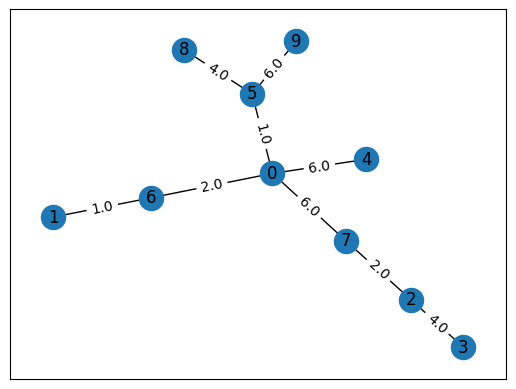

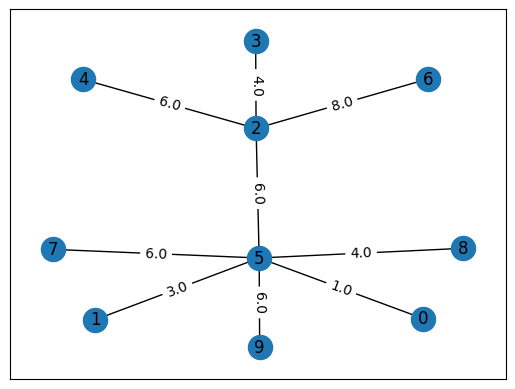

(tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.625],
 [5, 2, 2, 3, 2, 4, 5, 0, 5, 1, 5, 7, 5, 8, 2, 6, 5, 9])

In [23]:
_ ,a, b, c = agent_test.test(test_env)
util.show_data(test_env.min_tree)
test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c

In [47]:
util.get_node_sums(loaded_graph)

tensor([[ 8.,  2.,  6.,  5.,  1.,  3.,  7.,  4.,  0.,  9.],
        [34., 35., 40., 44., 49., 54., 54., 55., 56., 59.]])

In [48]:
util.get_out_edges(loaded_graph)

tensor([[8., 2., 1., 3., 4., 6., 9., 7., 0., 5.],
        [5., 6., 7., 7., 7., 7., 7., 8., 9., 9.]])